<a href="https://colab.research.google.com/github/Muhaiman-Bukhsh/Ai/blob/main/Parkinson_Progression_XAI_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Parkinson's Progression Detection with ML & SHAP
This notebook explores early detection of Parkinson’s disease progression using Random Forest and XGBoost models, combined with SHAP for explainability. We use the UCI Parkinson’s Telemonitoring dataset.

We define a progression proxy by classifying subjects based on median UPDRS scores and analyze key features that influence model decisions.

In [ ]:
# 📦 Install Required Libraries
!pip install pandas numpy scikit-learn xgboost imbalanced-learn shap matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"
df = pd.read_csv(url)
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [ ]:
# Create binary target from 'motor_UPDRS' using median as threshold
threshold = df['motor_UPDRS'].median()
y = (df['motor_UPDRS'] > threshold).astype(int)

# Use all columns except IDs and target labels
X = df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'subject#'])

### 🧪 Class Imbalance Handling with SMOTE
The motor_UPDRS target is binarized by the median value. We use SMOTE to balance the class distribution and improve model fairness.

In [ ]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

print("Balanced class distribution:\n", y_bal.value_counts())

Balanced class distribution:
 motor_UPDRS
1    2939
0    2939
Name: count, dtype: int64


### 🧠 Model Training and Evaluation
We train two models — Random Forest and XGBoost — to predict Parkinson’s progression. We'll evaluate and compare their performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       588
           1       0.94      0.93      0.94       588

    accuracy                           0.94      1176
   macro avg       0.94      0.94      0.94      1176
weighted avg       0.94      0.94      0.94      1176



### 🔍 Model Explainability with SHAP
SHAP is used to explain which features most influence the model's decisions, offering transparency for clinical use.

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       588
           1       1.00      0.99      0.99       588

    accuracy                           0.99      1176
   macro avg       0.99      0.99      0.99      1176
weighted avg       0.99      0.99      0.99      1176



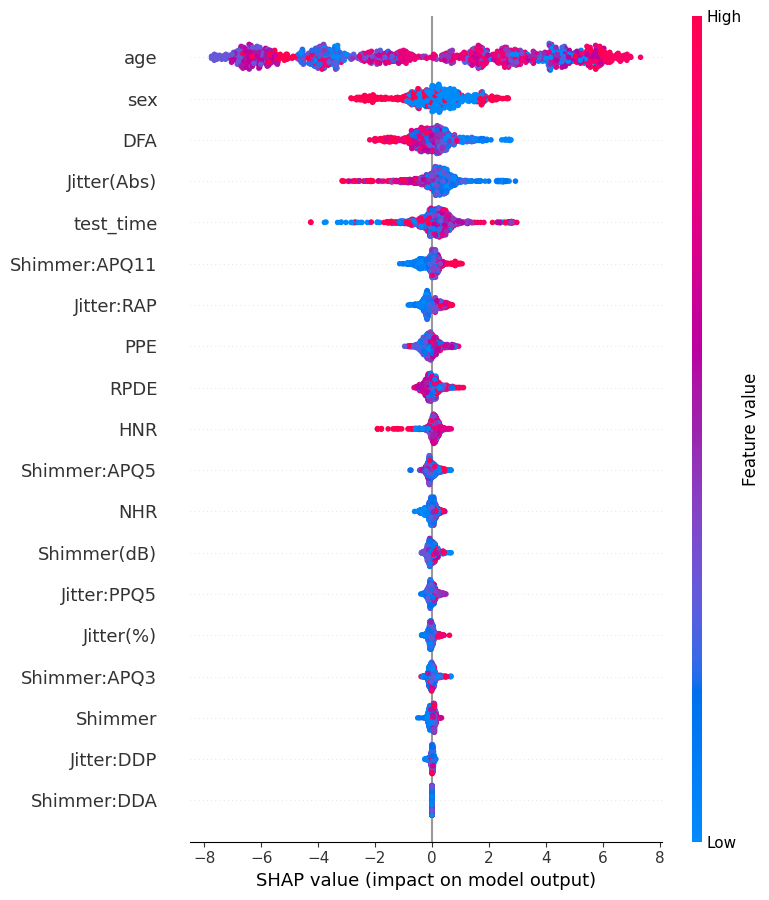

In [ ]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

In [ ]:
plt.show()
plt.tight_layout()
plt.savefig("shap_summary_plot.png")


<Figure size 640x480 with 0 Axes>

In [ ]:
# 🧍 Example new patient (same number of features, use real values)
# Get the correct feature names from the training data
correct_features = X_train.columns.tolist()

new_patient_data = {
    'age': 68.0,
    'sex': 0.0,
    'test_time': 180.0,
    'Jitter(%)': 0.005,
    'Jitter(Abs)': 0.00003,
    # Add the missing Jitter features based on the traceback
    'Jitter:RAP': 0.002, # Example value
    'Jitter:PPQ5': 0.003, # Example value
    'Jitter:DDP': 0.006, # Example value
    'Shimmer': 0.03,
    'Shimmer(dB)': 0.25,
    'Shimmer:APQ3': 0.015,
    'Shimmer:APQ5': 0.02,
    # Add the missing Shimmer feature based on the traceback
    'Shimmer:APQ11': 0.025, # Example value
    'Shimmer:DDA': 0.045,
    'NHR': 0.02,
    'HNR': 20.0,
    'RPDE': 0.45,
    'DFA': 0.65,
    'PPE': 0.2
    # Remove 'spread1', 'spread2', 'D2' as they were not in training data
}

# Create the DataFrame, ensuring the columns match X_train and are in the same order
new_patient = pd.DataFrame([new_patient_data])[correct_features]


# Predict with XGBoost
prediction = xgb.predict(new_patient)[0]
probability = xgb.predict_proba(new_patient)[0][1]

print("Prediction:", "Advanced" if prediction == 1 else "Mild")
print("Probability of Advanced Parkinson's:", f"{probability:.2f}")

Prediction: Advanced
Probability of Advanced Parkinson's: 0.74


In [ ]:
# 🧍 Example new patient (representing a healthy person)
# Get the correct feature names from the training data
correct_features = X_train.columns.tolist()

# Create data for a hypothetical healthy person
# Lower values for Jitter, Shimmer, NHR, higher HNR, etc.
healthy_patient_data = {
    'age': 65.0,          # Typical age range
    'sex': 1.0,           # Example sex (0 or 1)
    'test_time': 200.0,   # Example test time
    'Jitter(%)': 0.002,   # Low Jitter
    'Jitter(Abs)': 0.00001, # Low Jitter
    'Jitter:RAP': 0.001,  # Low Jitter variant
    'Jitter:PPQ5': 0.0015, # Low Jitter variant
    'Jitter:DDP': 0.003,  # Low Jitter variant
    'Shimmer': 0.01,      # Low Shimmer
    'Shimmer(dB)': 0.1,   # Low Shimmer
    'Shimmer:APQ3': 0.005, # Low Shimmer variant
    'Shimmer:APQ5': 0.006, # Low Shimmer variant
    'Shimmer:APQ11': 0.007, # Low Shimmer variant
    'Shimmer:DDA': 0.015, # Low Shimmer variant
    'NHR': 0.005,         # Low NHR
    'HNR': 25.0,          # High HNR
    'RPDE': 0.3,          # Example RPDE
    'DFA': 0.55,          # Example DFA
    'PPE': 0.05           # Low PPE
    # Note: 'spread1', 'spread2', 'D2' were excluded as per the training data
}

# Create the DataFrame, ensuring the columns match X_train and are in the same order
healthy_patient = pd.DataFrame([healthy_patient_data])[correct_features]

# Predict with XGBoost for the healthy patient
healthy_prediction = xgb.predict(healthy_patient)[0]
healthy_probability = xgb.predict_proba(healthy_patient)[0][1]


print("Prediction:", "Advanced" if healthy_prediction == 1 else "Mild")
print("Probability of Advanced Parkinson's:", f"{healthy_probability:.2f}")

Prediction: Mild
Probability of Advanced Parkinson's: 0.00


In [ ]:
# 🧍 Example new patient
correct_features = X_train.columns.tolist()

intermediate_parkinsons_data = {
    'age': 61.0,          # Example age
    'sex': 0.0,           # Example sex (0 or 1)
    'test_time': 250.0,   # Example test time
    'Jitter(%)': 0.0004,   # Intermediate Jitter
    'Jitter(Abs)': 0.00002, # Intermediate Jitter
    'Jitter:RAP': 0.0015, # Intermediate Jitter variant
    'Jitter:PPQ5': 0.002, # Intermediate Jitter variant
    'Jitter:DDP': 0.0045, # Intermediate Jitter variant
    'Shimmer': 0.02,      # Intermediate Shimmer
    'Shimmer(dB)': 0.2,   # Intermediate Shimmer
    'Shimmer:APQ3': 0.01, # Intermediate Shimmer variant
    'Shimmer:APQ5': 0.015, # Intermediate Shimmer variant
    'Shimmer:APQ11': 0.02, # Intermediate Shimmer variant
    'Shimmer:DDA': 0.03, # Intermediate Shimmer variant
    'NHR': 0.015,         # Intermediate NHR
    'HNR': 12.0,          # Intermediate HNR
    'RPDE': 0.4,          # Example RPDE
    'DFA': 0.6,           # Example DFA
    'PPE': 0.15           # Intermediate PPE
}

# Create the DataFrame, ensuring the columns match X_train
intermediate_patient = pd.DataFrame([intermediate_parkinsons_data])[correct_features]

# Predict with XGBoost for the intermediate patient
intermediate_prediction = xgb.predict(intermediate_patient)[0]
intermediate_probability = xgb.predict_proba(intermediate_patient)[0][1]


print("Prediction:", "Advanced" if intermediate_prediction == 1 else "Mild")
print("Probability of Advanced Parkinson's:", f"{intermediate_probability:.2f}")

Prediction: Mild
Probability of Advanced Parkinson's: 0.22
